# Modeling & Forecast
Time series diagnostics, SARIMA/ETS model comparison, and forecast (train: 2001-2009, test: 2010, forecast: 2011). Builds candidate time-series models for the monthly pulmonary tuberculosis series, performs backtesting on 2010, compares metrics, and produces a final forecast for 2011 with prediction intervals.

In [1]:
# EN/PT: Setup imports, flags, paths, plotting defaults
DEBUG = True
LANGUAGE = "EN"

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Plot defaults
plt.rcParams.update({"figure.figsize": (12, 5), "font.size": 12})
sns.set_style("whitegrid")

DATA_DIR = Path("processed_data")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)

def debug(en_msg, pt_msg=""):
    if not DEBUG:
        return
    print("[DEBUG]", en_msg if LANGUAGE.upper()=="EN" else (pt_msg if pt_msg else en_msg))

In [2]:
# EN/PT: Load monthly series CSV produced by preprocessing. Expect columns: date (or date_parsed) and cases
fn_monthly = DATA_DIR / "monthly_pulmonary_tb_by_month.csv"
if not fn_monthly.exists():
    raise FileNotFoundError(f"Monthly CSV not found: {fn_monthly} — run preprocessing first. / CSV mensal não encontrado: {fn_monthly} — rode o pré-processamento primeiro.")

df = pd.read_csv(fn_monthly, parse_dates=["date"] if "date" in pd.read_csv(fn_monthly, nrows=0).columns else None, low_memory=False)

# Ensure date column exists (try date_parsed fallback)
if "date" not in df.columns and "date_parsed" in df.columns:
    df = df.rename(columns={"date_parsed":"date"})

if "date" not in df.columns:
    # try build from year/month
    if "year" in df.columns and "month" in df.columns:
        df["date"] = pd.to_datetime(df["year"].astype(int).astype(str) + "-" + df["month"].astype(int).astype(str) + "-01", errors="coerce")
    else:
        raise SystemExit("No 'date' column and no year/month to construct it. / Sem coluna 'date' nem year/month para construir.")

df = df.sort_values("date").reset_index(drop=True)
df = df[["date","cases"]].copy()
df["cases"] = pd.to_numeric(df["cases"], errors="coerce").fillna(0).astype(int)

# Keep only up to 2010-12-31 (if dataset includes later)
cutoff = pd.to_datetime("2010-12-31")
df = df[df["date"] <= cutoff].copy()

# Set index
df = df.set_index("date").asfreq("MS")  # monthly start frequency; missing months will be NaN
series = df["cases"].fillna(0)  # for modeling we may need to handle NaNs; temporarily fill 0 for display

debug(f"Loaded monthly series with {len(series)} points from {series.index.min().date()} to {series.index.max().date()}",
    f"Série mensal carregada com {len(series)} pontos de {series.index.min().date()} a {series.index.max().date()}")

display(series.head(24))

[DEBUG] Loaded monthly series with 120 points from 2001-01-01 to 2010-12-01


date
2001-01-01    236
2001-02-01    174
2001-03-01    219
2001-04-01    178
2001-05-01    295
2001-06-01    225
2001-07-01    225
2001-08-01    260
2001-09-01    213
2001-10-01    221
2001-11-01    234
2001-12-01    208
2002-01-01    219
2002-02-01    233
2002-03-01    237
2002-04-01    285
2002-05-01    268
2002-06-01    175
2002-07-01    242
2002-08-01    278
2002-09-01    242
2002-10-01    247
2002-11-01    229
2002-12-01    176
Freq: MS, Name: cases, dtype: int64

[DEBUG] Saved STL decomposition: figures\stl_sarima_diagnostics.png


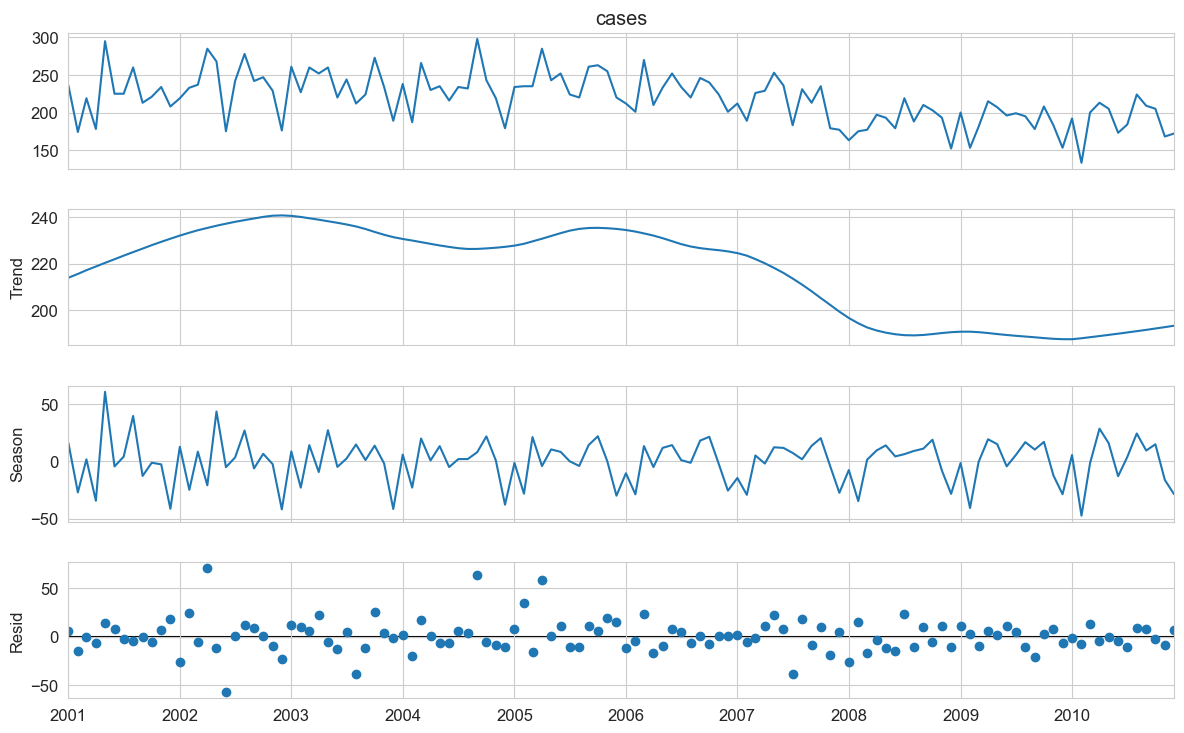

[DEBUG] Saved ACF plot: figures\acf_for_model.png


<Figure size 1200x400 with 0 Axes>

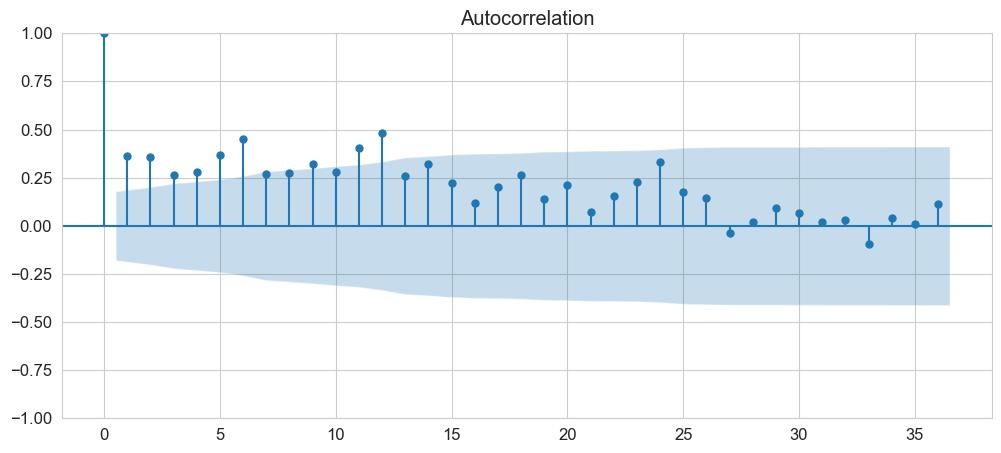

[DEBUG] Saved PACF plot: figures\pacf_for_model.png


<Figure size 1200x400 with 0 Axes>

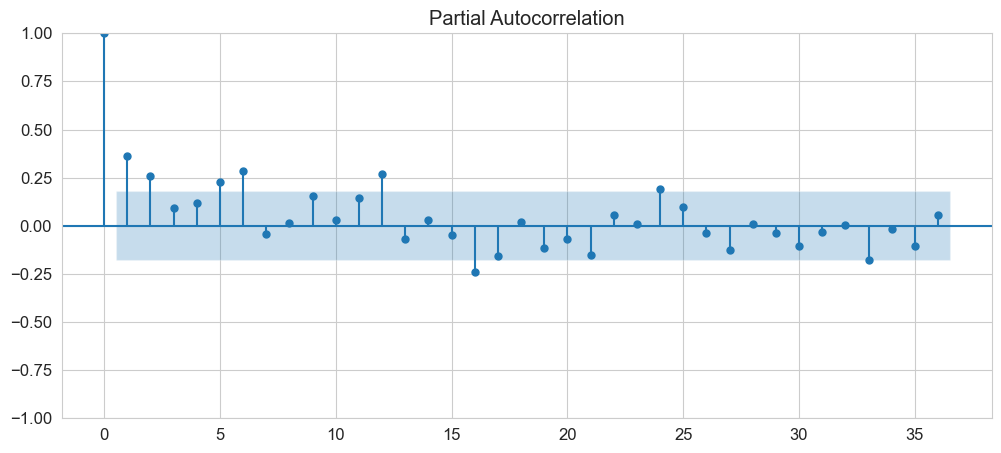

In [3]:
# EN/PT: STL decomposition and ACF/PACF plots
stl = STL(series, period=12, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12,8)
stl_path = FIG_DIR / "stl_sarima_diagnostics.png"
fig.savefig(stl_path, bbox_inches="tight", dpi=150)
debug(f"Saved STL decomposition: {stl_path}", f"STL salvo: {stl_path}")
plt.show()

# ACF/PACF
plt.figure(figsize=(12,4))
plot_acf(series, lags=36)
acf_path = FIG_DIR / "acf_for_model.png"
plt.savefig(acf_path, bbox_inches="tight", dpi=150)
debug(f"Saved ACF plot: {acf_path}", f"ACF salvo: {acf_path}")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series, lags=36, method='ywm')
pacf_path = FIG_DIR / "pacf_for_model.png"
plt.savefig(pacf_path, bbox_inches="tight", dpi=150)
debug(f"Saved PACF plot: {pacf_path}", f"PACF salvo: {pacf_path}")
plt.show()

In [4]:
# EN/PT: Run ADF and KPSS tests to check stationarity
def adf_test(x):
    r = adfuller(x.dropna(), autolag='AIC')
    return {"adf_stat": r[0], "pvalue": r[1], "usedlag": r[2], "nobs": r[3]}

def kpss_test(x):
    r = kpss(x.dropna(), nlags="auto")
    return {"kpss_stat": r[0], "pvalue": r[1], "nlags": r[2]}

adf_res = adf_test(series)
kpss_res = kpss_test(series)

debug(f"ADF: {adf_res}", f"ADF: {adf_res}")
debug(f"KPSS: {kpss_res}", f"KPSS: {kpss_res}")

print("ADF p-value (stationary if < 0.05):", adf_res["pvalue"])
print("KPSS p-value (stationary if > 0.05):", kpss_res["pvalue"])


[DEBUG] ADF: {'adf_stat': np.float64(-0.1336252600177193), 'pvalue': np.float64(0.9459846181820498), 'usedlag': 11, 'nobs': 108}
[DEBUG] KPSS: {'kpss_stat': np.float64(1.416264350338277), 'pvalue': np.float64(0.01), 'nlags': 5}
ADF p-value (stationary if < 0.05): 0.9459846181820498
KPSS p-value (stationary if > 0.05): 0.01


C:\Users\ioann\AppData\Local\Temp\ipykernel_37000\2822877000.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  r = kpss(x.dropna(), nlags="auto")


In [5]:
# EN/PT: Train/test split: train <= 2009-12-01, test = 2010-01..2010-12
train_end = pd.to_datetime("2009-12-01")
test_start = pd.to_datetime("2010-01-01")
test_end = pd.to_datetime("2010-12-01")

train = series[series.index <= train_end].copy()
test = series[(series.index >= test_start) & (series.index <= test_end)].copy()

debug(f"Train points: {len(train)}, Test points: {len(test)}", f"Treino: {len(train)}, Teste: {len(test)}")
display(train.tail(6))
display(test.head(6))

[DEBUG] Train points: 108, Test points: 12


date
2009-07-01    199
2009-08-01    195
2009-09-01    178
2009-10-01    208
2009-11-01    183
2009-12-01    153
Freq: MS, Name: cases, dtype: int64

date
2010-01-01    192
2010-02-01    133
2010-03-01    200
2010-04-01    213
2010-05-01    205
2010-06-01    173
Freq: MS, Name: cases, dtype: int64

In [6]:
# EN/PT: Define evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero: mask zeros
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## Modeling strategy / Estratégia de modelagem

**EN:** We'll fit two families of models:
- SARIMA via statsmodels (seasonal order with s=12). We'll perform a small grid search over (p,d,q) x (P,D,Q) limited ranges to keep runtime reasonable.
- ETS (Holt-Winters) via statsmodels' ExponentialSmoothing as a benchmark.

We will evaluate on the 2010 holdout and choose the best model by RMSE/MAE/MAPE.

**PT-BR:** Ajustaremos duas famílias:
- SARIMA (statsmodels) com busca em grade limitada para (p,d,q)x(P,D,Q) com s=12.
- ETS (Holt-Winters) como benchmark.

Avaliaremos no conjunto de 2010 e escolheremos pelo RMSE/MAE/MAPE.

In [7]:
# EN/PT: SARIMA grid search (limited) — careful with runtime
# ranges chosen small to be practical
ps = [0,1,2]
ds = [0,1]
qs = [0,1,2]
Ps = [0,1]
Ds = [0,1]
Qs = [0,1]
s = 12

best_sarima = None
results = []
start_time = time.time()

# We'll fit SARIMA on TRAIN and forecast the 12 months of TEST, compute RMSE
for p,d,q in itertools.product(ps,ds,qs):
    for P,D,Q in itertools.product(Ps,Ds,Qs):
        order = (p,d,q)
        seasonal_order = (P,D,Q,s)
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, method="lbfgs", maxiter=200)
            # forecast for test period
            pred = res.get_forecast(steps=len(test))
            yhat = pred.predicted_mean
            score_rmse = rmse(test.values, yhat.values)
            score_mae = mae(test.values, yhat.values)
            score_mape = mape(test.values, yhat.values)
            results.append({"order":order, "seasonal_order":seasonal_order, "rmse":score_rmse, "mae":score_mae, "mape":score_mape, "aic":res.aic})
            debug(f"SARIMA tried order={order} seasonal={seasonal_order} RMSE={score_rmse:.2f}", f"SARIMA testado order={order} seasonal={seasonal_order} RMSE={score_rmse:.2f}")
        except Exception as e:
            debug(f"SARIMA failed for order={order} seasonal={seasonal_order}: {e}", f"SARIMA falhou para order={order} seasonal={seasonal_order}: {e}")
            continue

# collect results DataFrame
df_sarima_results = pd.DataFrame(results).sort_values("rmse").reset_index(drop=True)
debug(f"SARIMA grid search completed in {time.time()-start_time:.1f}s; best candidate: {df_sarima_results.iloc[0].to_dict() if not df_sarima_results.empty else 'none'}",
    f"Busca SARIMA concluída em {time.time()-start_time:.1f}s; melhor candidato: {df_sarima_results.iloc[0].to_dict() if not df_sarima_results.empty else 'nenhum'}")

display(df_sarima_results.head(10))

[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(0, 0, 0, 12) RMSE=191.36
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(0, 0, 1, 12) RMSE=100.61
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(0, 1, 0, 12) RMSE=18.22
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(0, 1, 1, 12) RMSE=17.63
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(1, 0, 0, 12) RMSE=19.13
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(1, 0, 1, 12) RMSE=17.13
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(1, 1, 0, 12) RMSE=18.58
[DEBUG] SARIMA tried order=(0, 0, 0) seasonal=(1, 1, 1, 12) RMSE=18.48
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(0, 0, 0, 12) RMSE=186.58
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(0, 0, 1, 12) RMSE=103.22
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(0, 1, 0, 12) RMSE=18.22
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(0, 1, 1, 12) RMSE=17.71
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(1, 0, 0, 12) RMSE=19.14
[DEBUG] SARIMA tried order=(0, 0, 1) seasonal=(1, 0, 1, 12) RMSE=17.33
[D

d:\Desenvolvimento\LIBs\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[DEBUG] SARIMA tried order=(1, 0, 1) seasonal=(1, 0, 1, 12) RMSE=27.15
[DEBUG] SARIMA tried order=(1, 0, 1) seasonal=(1, 1, 0, 12) RMSE=21.66
[DEBUG] SARIMA tried order=(1, 0, 1) seasonal=(1, 1, 1, 12) RMSE=20.01
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(0, 0, 0, 12) RMSE=25.14
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(0, 0, 1, 12) RMSE=22.98
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(0, 1, 0, 12) RMSE=18.17
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(0, 1, 1, 12) RMSE=18.55
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(1, 0, 0, 12) RMSE=22.55
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(1, 0, 1, 12) RMSE=26.75
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(1, 1, 0, 12) RMSE=21.48
[DEBUG] SARIMA tried order=(1, 0, 2) seasonal=(1, 1, 1, 12) RMSE=21.69
[DEBUG] SARIMA tried order=(1, 1, 0) seasonal=(0, 0, 0, 12) RMSE=35.56
[DEBUG] SARIMA tried order=(1, 1, 0) seasonal=(0, 0, 1, 12) RMSE=31.11
[DEBUG] SARIMA tried order=(1, 1, 0) seasonal=(0, 1, 0, 12) RMSE=18.68
[DEBUG

,order,seasonal_order,rmse,mae,mape,aic
0,"(0, 0, 2)","(1, 0, 1, 12)",16.839334,12.918403,7.460827,888.761811
1,"(2, 0, 0)","(1, 0, 1, 12)",16.910428,13.280238,7.622673,896.017632
2,"(0, 0, 0)","(1, 0, 1, 12)",17.134105,13.267942,7.730490,910.566354
3,"(2, 1, 0)","(0, 1, 1, 12)",17.150715,13.885221,7.667771,772.370690
4,"(0, 0, 1)","(1, 0, 1, 12)",17.334701,13.438185,7.772014,899.078522
5,"(1, 1, 2)","(0, 1, 1, 12)",17.340184,13.920998,7.708352,743.878353
6,"(0, 1, 0)","(1, 1, 1, 12)",17.481283,14.007095,7.700059,816.644475
7,"(0, 0, 2)","(0, 1, 1, 12)",17.572592,14.509813,8.270290,771.231840
8,"(0, 0, 0)","(0, 1, 1, 12)",17.629622,14.752220,8.332729,791.020202
9,"(0, 0, 1)","(0, 1, 1, 12)",17.708116,14.658878,8.328039,783.479433


In [8]:
# EN/PT: Fit the best SARIMA from grid search on full TRAIN data (retrain) and produce forecast for 2011 (12 months)
if df_sarima_results.empty:
    debug("No SARIMA candidate found — skipping SARIMA", "Nenhum candidato SARIMA encontrado — pulando SARIMA")
else:
    best = df_sarima_results.iloc[0]
    best_order = tuple(best["order"])
    best_seasonal = tuple(best["seasonal_order"])
    debug(f"Refitting best SARIMA order={best_order} seasonal={best_seasonal}", f"Refit do melhor SARIMA order={best_order} seasonal={best_seasonal}")

    sarima_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal, enforce_stationarity=False, enforce_invertibility=False)
    sarima_res = sarima_model.fit(disp=False, method="lbfgs", maxiter=500)
    # forecast for test (again, to show fitted vs actual)
    sarima_pred_test = sarima_res.get_forecast(steps=len(test))
    sarima_pred_mean_test = sarima_pred_test.predicted_mean
    sarima_pred_ci_test = sarima_pred_test.conf_int(alpha=0.05)

    # Forecast 12 months for 2011 (we'll do this after evaluating)
    sarima_forecast_2011 = sarima_res.get_forecast(steps=12)
    sarima_forecast_mean = sarima_forecast_2011.predicted_mean
    sarima_forecast_ci = sarima_forecast_2011.conf_int(alpha=0.05)

    # Save model using pickle
    import pickle
    with open(DATA_DIR / "sarima_model.pkl", "wb") as f:
        pickle.dump(sarima_res, f)

    debug("SARIMA model refit and saved to processed_data/sarima_model.pkl",
        "SARIMA refitado e salvo em processed_data/sarima_model.pkl")

[DEBUG] Refitting best SARIMA order=(0, 0, 2) seasonal=(1, 0, 1, 12)
[DEBUG] SARIMA model refit and saved to processed_data/sarima_model.pkl


In [9]:
# EN/PT: Fit ETS (Holt-Winters) on TRAIN and forecast
# We'll try additive trend + additive seasonality as baseline; user can tune
try:
    ets = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated")
    ets_res = ets.fit(optimized=True)
    ets_pred_test = ets_res.forecast(steps=len(test))
    ets_forecast_2011 = ets_res.forecast(steps=12)  # forecast for 2011
    # Save ETS model
    import pickle
    with open(DATA_DIR / "ets_model.pkl", "wb") as f:
        pickle.dump(ets_res, f)
    debug("ETS model trained and saved", "ETS treinado e salvo")
except Exception as e:
    debug(f"ETS fitting failed: {e}", f"Falha no ajuste ETS: {e}")
    ets_res = None

[DEBUG] ETS model trained and saved


In [10]:
# EN/PT: Evaluate SARIMA and ETS on the 2010 test set
eval_rows = []
if not df_sarima_results.empty:
    sarima_yhat = sarima_pred_mean_test
    eval_rows.append({
        "model":"SARIMA",
        "rmse": rmse(test.values, sarima_yhat.values),
        "mae": mae(test.values, sarima_yhat.values),
        "mape": mape(test.values, sarima_yhat.values)
    })

if ets_res is not None:
    ets_yhat = ets_pred_test
    eval_rows.append({
        "model":"ETS",
        "rmse": rmse(test.values, ets_yhat.values),
        "mae": mae(test.values, ets_yhat.values),
        "mape": mape(test.values, ets_yhat.values)
    })

df_eval = pd.DataFrame(eval_rows).sort_values("rmse").reset_index(drop=True)
display(df_eval)
df_eval.to_csv(DATA_DIR / "model_evaluation_on_2010.csv", index=False)
debug("Saved evaluation table to processed_data/model_evaluation_on_2010.csv",
    "Avaliação salva em processed_data/model_evaluation_on_2010.csv")

,model,rmse,mae,mape
0,SARIMA,16.839334,12.918403,7.460827
1,ETS,22.096952,17.953131,9.394214


[DEBUG] Saved evaluation table to processed_data/model_evaluation_on_2010.csv


[DEBUG] Saved prediction vs actual plot: figures\model_predictions_vs_actual_2010.png


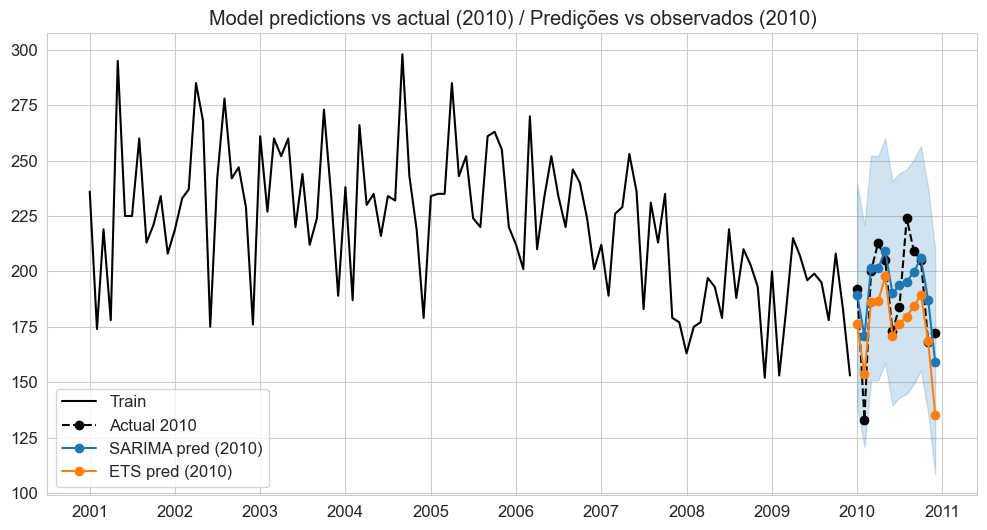

In [11]:
# EN/PT: Plot test period (2010) actual vs predictions (SARIMA and ETS)
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train", color="black")
plt.plot(test.index, test, label="Actual 2010", color="black", linestyle="--", marker='o')

if not df_sarima_results.empty:
    plt.plot(test.index, sarima_pred_mean_test, label="SARIMA pred (2010)", marker='o')
    ci = sarima_pred_ci_test
    plt.fill_between(test.index, ci.iloc[:,0], ci.iloc[:,1], color='C0', alpha=0.2)

if ets_res is not None:
    plt.plot(test.index, ets_pred_test, label="ETS pred (2010)", marker='o')

plt.title("Model predictions vs actual (2010) / Predições vs observados (2010)")
plt.legend()
plt.grid(True)
plt_path = FIG_DIR / "model_predictions_vs_actual_2010.png"
plt.savefig(plt_path, bbox_inches="tight", dpi=150)
debug(f"Saved prediction vs actual plot: {plt_path}", f"Plot predições vs observados salvo: {plt_path}")
plt.show()

In [12]:
# EN/PT: Produce and save final 2011 forecasts (SARIMA and ETS) with intervals where available
forecasts = []

if not df_sarima_results.empty:
    sarima_fc = sarima_forecast_mean
    sarima_ci = sarima_forecast_ci
    sarima_df = pd.DataFrame({
        "date": pd.date_range(start="2011-01-01", periods=12, freq="MS"),
        "forecast_sarima": sarima_fc.values,
        "lower_sarima": sarima_ci.iloc[:,0].values,
        "upper_sarima": sarima_ci.iloc[:,1].values
    })
    forecasts.append(sarima_df)

if ets_res is not None:
    ets_fc = ets_forecast_2011
    ets_df = pd.DataFrame({
        "date": pd.date_range(start="2011-01-01", periods=12, freq="MS"),
        "forecast_ets": ets_fc.values
    })
    forecasts.append(ets_df)

# Merge forecasts if both exist
if forecasts:
    df_forecast = forecasts[0]
    for f in forecasts[1:]:
        df_forecast = df_forecast.merge(f, on="date", how="outer")
    df_forecast.to_csv(DATA_DIR / "forecast_2011_models.csv", index=False)
    debug("Saved 2011 forecasts to processed_data/forecast_2011_models.csv",
        "Previsões 2011 salvas em processed_data/forecast_2011_models.csv")
    display(df_forecast)
else:
    debug("No forecasts produced.", "Nenhuma previsão produzida.")

[DEBUG] Saved 2011 forecasts to processed_data/forecast_2011_models.csv


,date,forecast_sarima,lower_sarima,upper_sarima,forecast_ets
0,2011-01-01,189.285631,139.275803,239.295460,176.444306
1,2011-02-01,170.735688,120.726852,220.744524,153.537453
2,2011-03-01,201.537776,150.794340,252.281212,185.970118
3,2011-04-01,201.422183,150.817496,252.026869,186.537414
4,2011-05-01,209.253557,158.648870,259.858243,197.752751
5,2011-06-01,190.052204,139.447518,240.656891,171.043011
6,2011-07-01,193.652086,143.047400,244.256772,176.402655
7,2011-08-01,195.287931,144.683245,245.892618,179.443985
8,2011-09-01,199.933470,149.328784,250.538156,184.423498
9,2011-10-01,205.837726,155.233039,256.442412,189.289556


[DEBUG] Saved history + forecast plot: figures\history_plus_forecast_2011.png


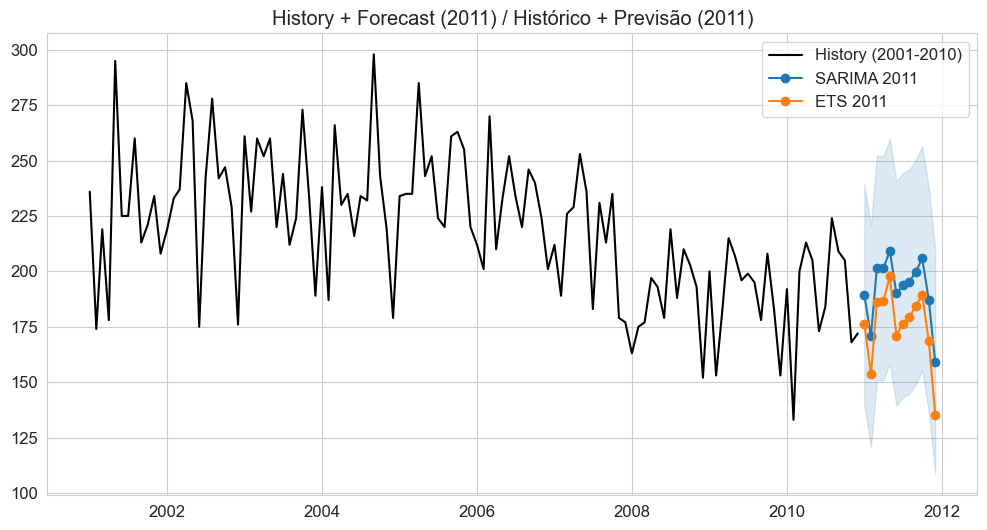

In [13]:
# EN/PT: Plot history (2001-2010) + forecasts for 2011 with intervals
plt.figure(figsize=(12,6))
plt.plot(series.index, series.values, label="History (2001-2010)", color="black")

if not df_sarima_results.empty:
    plt.plot(df_forecast["date"], df_forecast["forecast_sarima"], label="SARIMA 2011", marker='o')
    plt.fill_between(df_forecast["date"], df_forecast["lower_sarima"], df_forecast["upper_sarima"], color='C0', alpha=0.15)

if ets_res is not None:
    plt.plot(df_forecast["date"], df_forecast["forecast_ets"], label="ETS 2011", marker='o')

plt.title("History + Forecast (2011) / Histórico + Previsão (2011)")
plt.legend()
plt.grid(True)
plt_path = FIG_DIR / "history_plus_forecast_2011.png"
plt.savefig(plt_path, bbox_inches="tight", dpi=150)
debug(f"Saved history + forecast plot: {plt_path}", f"Histórico + previsão salvo: {plt_path}")
plt.show()

## Notes & interpretation / Notas e interpretação

**EN (short):**
- Compare SARIMA and ETS metrics saved in `processed_data/model_evaluation_on_2010.csv`.
- Inspect prediction intervals for SARIMA to understand uncertainty.
- If SARIMA and ETS disagree widely, present both to stakeholders and discuss assumptions.
- Consider improvements: longer grid search, exogenous regressors, treatment of outliers.

**PT-BR (curto):**
- Compare SARIMA e ETS nas métricas em `processed_data/model_evaluation_on_2010.csv`.
- Veja os intervalos do SARIMA para entender incerteza.
- Se SARIMA e ETS divergirem, apresente ambos e discuta suposições.
- Melhorias possíveis: busca maior, regressores exógenos, tratar outliers.

In [14]:
# EN/PT: Save key outputs and list files
print("Saved files in processed_data:")
for p in sorted(DATA_DIR.glob("*.csv")):
    print("-", p.name)
for p in sorted(DATA_DIR.glob("*.pkl")):
    print("-", p.name)

print("\nFigures in figures/:")
for p in sorted(FIG_DIR.glob("*.png")):
    print("-", p.name)

Saved files in processed_data:
- annual_pulmonary_tb_by_year.csv
- filtered_pulmonary_tb_rows.csv
- forecast_2011_models.csv
- model_evaluation_on_2010.csv
- monthly_pulmonary_tb_by_month.csv
- monthly_pulmonary_tb_by_month_flagged_outliers.csv
- ets_model.pkl
- sarima_model.pkl

Figures in figures/:
- acf_for_model.png
- acf_monthly.png
- boxplot_month_by_month.png
- heatmap_year_month_cases.png
- histogram_monthly_cases.png
- history_plus_forecast_2011.png
- model_predictions_vs_actual_2010.png
- pacf_for_model.png
- pacf_monthly.png
- stl_decomposition.png
- stl_sarima_diagnostics.png
- ts_monthly_cases_line.png
